## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link. 

**Update:** This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains many additional slides and masks you can use. Note that while the starter code below downloads one slide from a Google Cloud URL (we have hosted this online for you for convenience), you will need to find a way to work with the other slides yourself for practice. You do not need to use them all! Just a few. You can either host the slides you'll use on Cloud storage using any provider, or you can download from Google Drive in your notebook (this may be slow).

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

# Intro

In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (135 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   138M      0  0:00:03  0:00:03 --:--:--  138M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  59.1M      0 --:--:-- --:--:-- --:--:-- 59.1M


In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

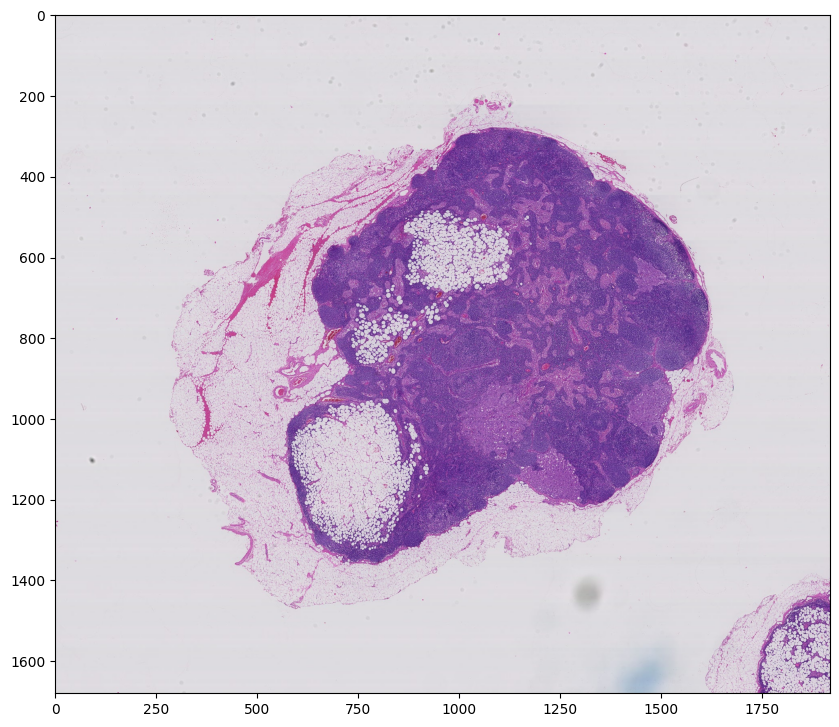

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

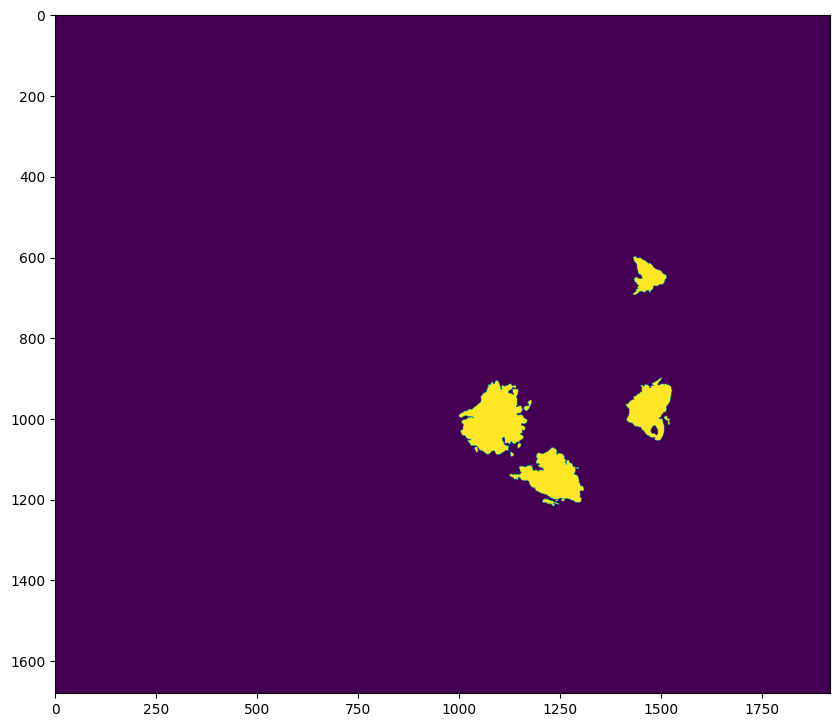

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

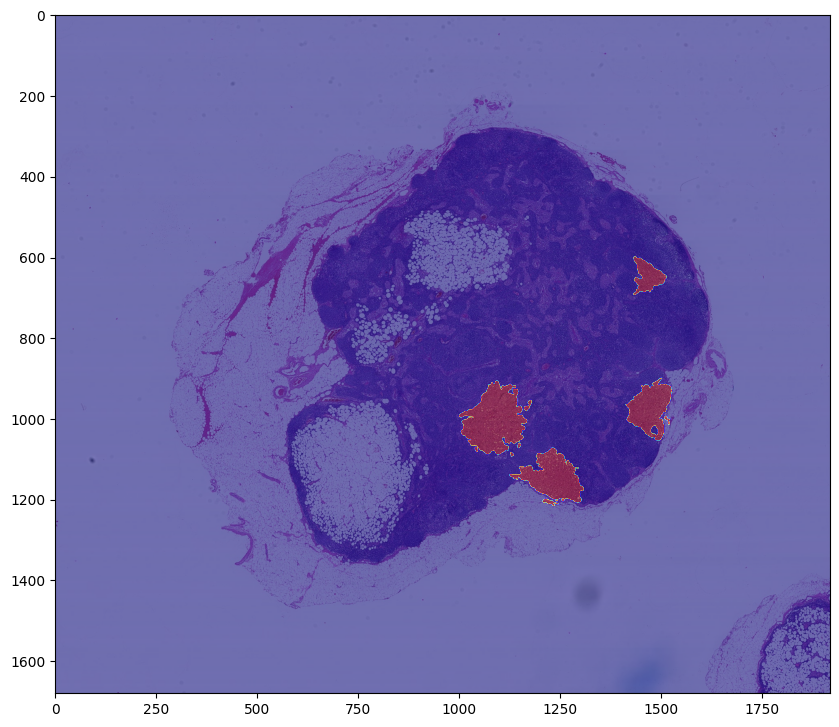

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

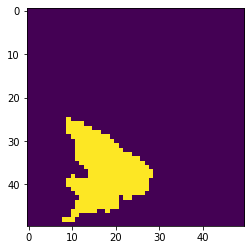

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=125 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


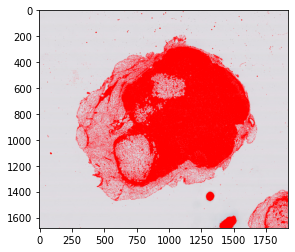

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

# Initialize all parameters

In [ ]:
# parameters for creating training set
train_slide_names = ['tumor_091.tif', 'tumor_110.tif']
train_image_num = [91, 110] # image number

# train_slide_names = ['tumor_091.tif']
# train_image_num = [91] # image number

train_levels = [2, 0]
# train_levels = [4, 3]
# train_levels = [5, 4]

train_batch_size = 8
width, height = 299, 299

In [ ]:
# parameters for creating testing set

In [ ]:
# parameters for training the models
epoch = 20
num_workers = 8

# Create Training Patches
1. use chosen slide to randomly extract patches of size (299,299)
2. only patch with 20% bottleneck tissue percentage will be kept as training set
3. create a directory with path name: slide_name, zoom_level
3. save patch w/ name format: x, y, label under corresponding directory
3. last cell is not used for now: need to define what slides are used

In [ ]:
import random
import pandas as pd
import math

In [ ]:
# slides will be stored inside several folders with name slide_name + zoom_level
def create_folder(slide_name, isTrain):
  # designated folder name
  directory = f"{slide_name}" 
  # directory = f"{slide_name}_{str(target_level)}" 

  # content directory
  if (isTrain):
    parent_dir = "./Train/"
  else:
    parent_dir = "./Test/"

  # combined path
  path = os.path.join(parent_dir, directory)

  # if the folder not exist, create, otherwise, pass
  try:
    if (not os.path.exists(parent_dir)):
      os.mkdir(parent_dir)

    if (not os.path.exists(path)):
      os.mkdir(path)
      return path
    else:
      return None   #return true so we don't extract patches again
  except:
    return None

In [ ]:
# get a slide and return tissue percentage
def compute_tissue_percent(slide_image):
  def find_tissue_pixels(image, intensity=0.8):
      im_gray = rgb2gray(image)
      assert im_gray.shape == (image.shape[0], image.shape[1])
      indices = np.where(im_gray <= intensity)
      return list(zip(indices[0], indices[1]))

  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  return percent_tissue

In [ ]:
# takes a list of windows, keep only patches that are non background
# bottlenect = 40%
def eliminate_background(all_windows, curr_slide, target_level, dimension_x, dimension_y):
  final_windows, percentages = [], []
  for (x, y) in all_windows:
    # extract target slides
    slide_image = read_slide(curr_slide, 
                            y=x*int(curr_slide.level_downsamples[target_level]), 
                            x=y*int(curr_slide.level_downsamples[target_level]), 
                            level=target_level, 
                            width=dimension_x, 
                            height=dimension_y)

    # compute percentage of tissue
    percentage = compute_tissue_percent(slide_image)
    percentages.append(percentage)

    # eliminate all patches that has < 40% tissues
    if (percentage >= 20):
      final_windows.append((x, y))

  return final_windows, percentages

In [ ]:
'''
  get label for current (x,y) patch, a helper function for sliding windows
  return: label 0/1 of (x,y) at curr_slide
'''
def get_label(x, y, curr_slide, slide_name, target_level_central, dimension_x, dimension_y):
  # open tumor mask
  tumor_mask = open_slide(f"{os.path.splitext(slide_name)[0]}_mask.tif")

  # extract the mask for all selected (x,y)'s center 128*128 pixels
  mask_image = read_slide(tumor_mask, 
                          y=x*int(curr_slide.level_downsamples[target_level_central]),
                          x=y*int(curr_slide.level_downsamples[target_level_central]), 
                          level=target_level_central, 
                          width=dimension_x, 
                          height=dimension_y)
  
  # sanity check: mask dimension
  assert (mask_image.shape[0] == dimension_x) and (mask_image.shape[1] == dimension_y)
  
  # get the label for the mask:
  # 1: tumor, 0: non-tumor
  if (len(np.where(mask_image == 1)[0]) > 0):
    label = 1
  else:
    label = 0

  return label

In [ ]:
'''
  select windows at random, a helper function for sliding windows
  return: a list of selected windows in form: [[x, y, label],...]
'''
def select_windows(all_windows, all_labels, curr_slide, slide_name, target_level_central, dimension_x, dimension_y, percent_kept):
  selected_windows = []
  for (x, y) in all_windows:   
      label = get_label(x, y, curr_slide, slide_name, target_level_central, dimension_x, dimension_y)   
      all_labels.append(label)
      
      # make sure only ~percent_kept percentage of patches are kept
      # and label == 1 must be selected 
      if (percent_kept < 1) and (label == 0):
        if (random.randint(1, 100) <= percent_kept*100):
          selected_windows.append([x, y, label])
      else:
        selected_windows.append([x, y, label])

  return selected_windows

In [ ]:
'''
  apply undersample on a pandas dataframe, majority label is nontumor cells
  -- keep number of normal patch 8* as more

  --- input ---
  df: dataframe of current slide to undersample
  majority label: class with more data
  minority label: class with less data
'''
def undersample(df, majority_label=0, minority_label=1):
  label_counts = df['label'].value_counts()
  majority_num, minority_num = label_counts.loc[0], label_counts[1]

  # compute number of majority label to eliminate
  num_to_eliminate = math.floor(majority_num/6) - minority_num

  # if there is no need to eliminate, return original df
  if (num_to_eliminate < 0):
    print("No undersampling performed...")
    print(f"Number of Majority class: {majority_num}, Number of minority class: {minority_num}")
    return df

  # compute fraction to eliminate
  elim_fraction = num_to_eliminate/majority_num

  # Select a random subset of the rows where the label is equal to the majority value
  undersampled_df = df[df['label'] == majority_label].sample(frac=1-elim_fraction)

  # Concatenate the undersampled data with the rest of the data
  undersampled_df = pd.concat([undersampled_df, df[df['label'] != majority_label]])

  # Sanity check: Number of original df, number of undersampled df, frac of majority label eliminated
  print("undersample sanity check:")
  print(f"length of original df: {len(df)}, length of undersampled df: {len(undersampled_df)}")
  print(f"Fraction to eliminate: {elim_fraction}, difference between two classes: {majority_num - minority_num}")

  return undersampled_df

In [ ]:
'''
  code used to save a patch from slide to png
  a helper function for save_image
'''
def save_image_helper(im, x, y, label, path, level, isaugment=False, k=0, flipped=0):
  try: 
    if (isaugment):
      filename = f"{level}_{str(x)}_{str(y)}_{str(label)}_{str(k)}_{str(flipped)}.png"
      filename = os.path.join(path, filename)
      im = Image.fromarray(im)
      im.save(filename)
    else:
      filename = f"{level}_{str(x)}_{str(y)}_{str(label)}_0_0.png"
      filename = os.path.join(path, filename)
      im.save(filename)
  
    return filename
  except Exception as e: 
    print(e)
    print(f"Error: file at location {str((x,y))} cannot be saved.")

In [ ]:
'''
  takes in a dataframe, perform augmentation on tumor cell, then save as image
  filename would be in format: x_y_label_k_flipped
  where k is the number of rotation
  - since label 0 are not augmented, both k and flipped will be 0
'''
def save_image(slide, x, y, offset_x, offset_y, target_level_background, zoom_level, target_dim_x, target_dim_y, path, label, do_augment=True):
  # sanity check: make sure zoom level is lower level than target level
  assert (zoom_level < target_level_background)

  # extract the background slide, default: (299,299) from the same level
  background_image = read_slide(slide, 
                                y=(x-offset_x)*int(slide.level_downsamples[target_level_background]), 
                                x=(y-offset_y)*int(slide.level_downsamples[target_level_background]), 
                                level=target_level_background, 
                                width=target_dim_x, 
                                height=target_dim_y)
  
  # sanity check: patch dimension
  assert (background_image.shape[0] == target_dim_x) and (background_image.shape[1] == target_dim_y)

  # compute x and y for slide2
  background_image_zoomed = read_slide(slide, 
                                      y=(x-offset_x+int((299-128)/2))*int(slide.level_downsamples[target_level_background]), 
                                      x=(y-offset_y+int((299-128)/2))*int(slide.level_downsamples[target_level_background]), 
                                      level=zoom_level, 
                                      width=target_dim_x, 
                                      height=target_dim_y)
  
  # sanity check: patch dimension
  assert (background_image_zoomed.shape[0] == target_dim_x) and (background_image_zoomed.shape[1] == target_dim_y)

  # save these slides to images
  # image name: x, y, label, unique_id
  im1, im2 = Image.fromarray(background_image), Image.fromarray(background_image_zoomed)

  if (label == 0) or ((label == 1) and (not do_augment)):
    filename1 = save_image_helper(im1, x, y, label, path, level=target_level_background)
    filename2 = save_image_helper(im2, x, y, label, path, level=zoom_level)
  
  # apply data augmentation for tumor images: flip and rotate
  else:
    # save original image
    filename1 = save_image_helper(im1, x, y, label, path, level=target_level_background)
    filename2 = save_image_helper(im2, x, y, label, path, level=zoom_level)

    # rotate original image
    for k in range(1,4):
      save_image_helper(np.rot90(im1, k=k), x, y, label, path, isaugment=True, k=k, flipped=0, level=target_level_background)
      save_image_helper(np.rot90(im2, k=k), x, y, label, path, isaugment=True, k=k, flipped=0, level=zoom_level)

    # rotate flipped image
    # for k in range(1,4):
    #   save_image_helper(np.rot90(np.fliplr(im1), k=k), x, y, label, path, isaugment=True, k=k, flipped=1, level=target_level_background)
    #   save_image_helper(np.rot90(np.fliplr(im2), k=k), x, y, label, path, isaugment=True, k=k, flipped=1, level=zoom_level)

  return filename1, filename2

In [ ]:
# '''
#   takes in a dataframe, perform augmentation on tumor cell, then save as image
#   filename would be in format: x_y_label_k_flipped
#   where k is the number of rotation
#   - since label 0 are not augmented, both k and flipped will be 0
# '''
# def save_image(slide, x, y, offset_x, offset_y, target_level_background, zoom_level, target_dim_x, target_dim_y, path, label, do_augment=True):
#   # sanity check: make sure zoom level is lower level than target level
#   assert (zoom_level < target_level_background)

#   # extract the background slide, default: (299,299) from the same level
#   background_image = read_slide(slide, 
#                                 y=(x-offset_x)*int(slide.level_downsamples[target_level_background]), 
#                                 x=(y-offset_y)*int(slide.level_downsamples[target_level_background]), 
#                                 level=target_level_background, 
#                                 width=target_dim_x, 
#                                 height=target_dim_y)
  
#   # sanity check: patch dimension
#   assert (background_image.shape[0] == target_dim_x) and (background_image.shape[1] == target_dim_y)

#   # compute x and y for slide2
#   background_image_zoomed = read_slide(slide, 
#                                       y=(x-offset_x)*int(slide.level_downsamples[target_level_background]), 
#                                       x=(y-offset_y)*int(slide.level_downsamples[target_level_background]), 
#                                       level=target_level_background, 
#                                       width=target_dim_x, 
#                                       height=target_dim_y)
  
#   # sanity check: patch dimension
#   assert (background_image_zoomed.shape[0] == target_dim_x) and (background_image_zoomed.shape[1] == target_dim_y)

#   # save these slides to images
#   # image name: x, y, label, unique_id
#   im1, im2 = Image.fromarray(background_image), Image.fromarray(background_image_zoomed)

#   if (label == 0) or ((label == 1) and (not do_augment)):
#     filename1 = save_image_helper(im1, x, y, label, path, level=target_level_background)
#     # filename2 = save_image_helper(im2, x, y, label, path, level=zoom_level)
  
#   # apply data augmentation for tumor images: flip and rotate
#   else:
#     # save original image
#     filename1 = save_image_helper(im1, x, y, label, path, level=target_level_background)
#     # filename2 = save_image_helper(im2, x, y, label, path, level=zoom_level)

#     # rotate original image
#     for k in range(1,4):
#       save_image_helper(np.rot90(im1, k=k), x, y, label, path, isaugment=True, k=k, flipped=0, level=target_level_background)
#       # save_image_helper(np.rot90(im2, k=k), x, y, label, path, isaugment=True, k=k, flipped=0, level=zoom_level)

#     # rotate flipped image
#     for k in range(1,4):
#       save_image_helper(np.rot90(np.fliplr(im1), k=k), x, y, label, path, isaugment=True, k=k, flipped=1, level=target_level_background)
#       # save_image_helper(np.rot90(np.fliplr(im2), k=k), x, y, label, path, isaugment=True, k=k, flipped=1, level=zoom_level)

#   return filename1, filename1

In [ ]:
'''
usage:
  helper function for sanity check in sliding window function
  count number of positive and negative labels in training set path: path
'''
def count_labels(path):
  # get all filenames
  files = os.listdir(path)

  # remove file extension and get labels
  labels = [int(os.path.splitext(f)[0].split("_")[3]) for f in files]

  # return counted labels
  return labels.count(0), labels.count(1)

In [ ]:
'''
  usage: slide a window of size (128*128) across the slide and get the truth labels,
         using offset around the edges of course...
         then for each window, get 229*229 context patch to save into pngs...

  --- input ---
  slide_name: the name of the slide we want to extract patch from
  target_level_central: central patch target level (where we get label from)
  target_level_background: background patch target level (where we get background from)
      central and background should be the samein baseline

  percent_kept: percent of patch kept (add randomness), default 30%
  dimension_x, dimension_y: dimension of central patch (for prediction)
  target_dim_x, target_dim_y: dimension of background patch
  isTrain: whether we are creating training or validation set
'''

def sliding_window(slide_name, target_level_central, target_level_background, zoom_level, percent_kept=0.3, dimension_x=128, \
                   dimension_y=128, target_dim_x=299, target_dim_y=299, isTrain=True):
  
  # get target slide 1
  curr_slide1 = open_slide(slide_name)

  # get tumor mask slide
  tumor_mask = open_slide(f"{os.path.splitext(slide_name)[0]}_mask.tif")

  # compute offset between center-image and background image
  offset_x, offset_y = int((target_dim_x - dimension_x)/2), int((target_dim_y - dimension_y)/2)

  # get width and height of the slide
  width, height = curr_slide1.level_dimensions[target_level_central][0], curr_slide1.level_dimensions[target_level_central][1]

  # get all slide windows from (0, 0) to (x-dimension_x, y-dimension_y)
  # left -> right, up -> down
  all_windows = []
  for x_curr in range(offset_y, height-target_dim_y, dimension_y):
    for y_curr in range(offset_x, width-target_dim_x, dimension_x):
      all_windows.append((x_curr, y_curr))

  # eliminate background slides
  if (isTrain):
    all_windows, _ = eliminate_background(all_windows, curr_slide1, target_level_central, \
                                          dimension_x=dimension_x, dimension_y=dimension_y)

  # init return values for sanity check
  all_labels, filenames_original, filenames_zoomed = [], [], []
  selected_windows = []

  # create folder
  path = create_folder(slide_name, isTrain)

  # select windows based randomly for label 0, 100% for label 1
  selected_windows = select_windows(all_windows, all_labels, curr_slide1, slide_name, target_level_central, dimension_x, dimension_y, percent_kept)

  # generate a data frame first for DownSampling: columns [(x,y), label]
  df = pd.DataFrame(selected_windows, columns =['x', 'y', 'label']) 

  # undersample dataframe so that normal cells are 8 times more than tumor cell
  df_undersampled = undersample(df, majority_label=0, minority_label=1)

  do_augment = True
  if (slide_name == "tumor_110.tif"):
    do_augment = False

  if (path != None):
    # Iterate through the rows to save images
    for index, row in df.iterrows():
      # Access data for each column by column name
      x, y, label = row['x'], row['y'], row['label']
      filename_original, filename_zoomed = save_image(curr_slide1, x, y, offset_x, offset_y, target_level_background, \
                            zoom_level, target_dim_x, target_dim_y, path, label, do_augment=do_augment)
      
      filenames_original.append(filename_original)
      filenames_zoomed.append(filename_zoomed)

    # Sanity Check: print number of positive and negative labels
    print(f"Number of positive labels: {np.sum(all_labels == 1)}, Number of negative labels: {np.sum(all_labels == 0)}")
    print(f"Total number of images saved (level:{target_level_background}): {len(filenames_original)}, such as {filenames_original[0]}")
    print(f"Total number of images saved (level:{zoom_level}): {len(filenames_original)}, such as {filenames_original[0]}")

  # sanity check: number of labels in the training set
  num0, num1 = count_labels(f"/content/Train/{slide_name}/")
  print(f"Slide {slide}'s training set has {num0} tissue images and {num1} tumor images.")

  return all_windows, all_labels, filenames_original, filenames_zoomed

# Create Training Set
1. create a pandas dataframe with columns [unique_id, image_path, zoom_level, slide_name, has_tumor]

  a. unique_id are assigned after aggregate all images together

2. train_df consists of all selected training patches

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
tf.executing_eagerly()

True

In [ ]:
'''
  function that can download given slide using given slide's path
  --- input ---
  slide_name: the name of the slide
  slide_num: slide number
'''
def download_slide_mask(slide_name, slide_num):
  tumor_mask_path = f"{os.path.splitext(slide_name)[0]}_mask.tif" 

  if (slide_name == "tumor_091.tif"):
    slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_name
    mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path
  else:
    slide_url = "https://storage.googleapis.com/medical_images_tif/%s/%s" % (slide_num, slide_name)
    mask_url = "https://storage.googleapis.com/medical_images_tif/%s/%s" % (slide_num, tumor_mask_path)

  # import pdb; pdb.set_trace()

  # Download the whole slide image
  if not os.path.exists(slide_name):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url

  return True

In [ ]:
# create a patch extract loop for all slides and levels choosen
for i in range(len(train_slide_names)):
  # make sure slides are downloaded
  slide = train_slide_names[i]
  downloaded = download_slide_mask(slide, train_image_num[i])

  if (downloaded):
    out_level, zoom_level = train_levels[0], train_levels[1]
    # generate patch by sliding window to Training set
    print(sliding_window(slide_name=slide, target_level_central=out_level, target_level_background=out_level, zoom_level=zoom_level, percent_kept=1, isTrain=True))

undersample sanity check:
length of original df: 4105, length of undersampled df: 3751
Fraction to eliminate: 0.09262166405023547, difference between two classes: 3539
Number of positive labels: 0, Number of negative labels: 0
Total number of images saved (level:2): 4105, such as ./Train/tumor_091.tif/2_1109_7381_0_0_0.png
Total number of images saved (level:0): 4105, such as ./Train/tumor_091.tif/2_1109_7381_0_0_0.png
Slide tumor_091.tif's training set has 7644 tissue images and 2264 tumor images.
([(1109, 7381), (1621, 8277), (1621, 8405), (1621, 8533), (1749, 8277), (1749, 8405), (1749, 8533), (1749, 8661), (1749, 8789), (1749, 8917), (1877, 8021), (1877, 8149), (1877, 8277), (1877, 8533), (1877, 8661), (1877, 8789), (1877, 8917), (2005, 7765), (2005, 7893), (2005, 8021), (2005, 8149), (2005, 8277), (2005, 8533), (2005, 8661), (2005, 8789), (2005, 8917), (2133, 7765), (2133, 7893), (2133, 8021), (2133, 8149), (2133, 8277), (2133, 8405), (2133, 8533), (2133, 8661), (2133, 8789), (213

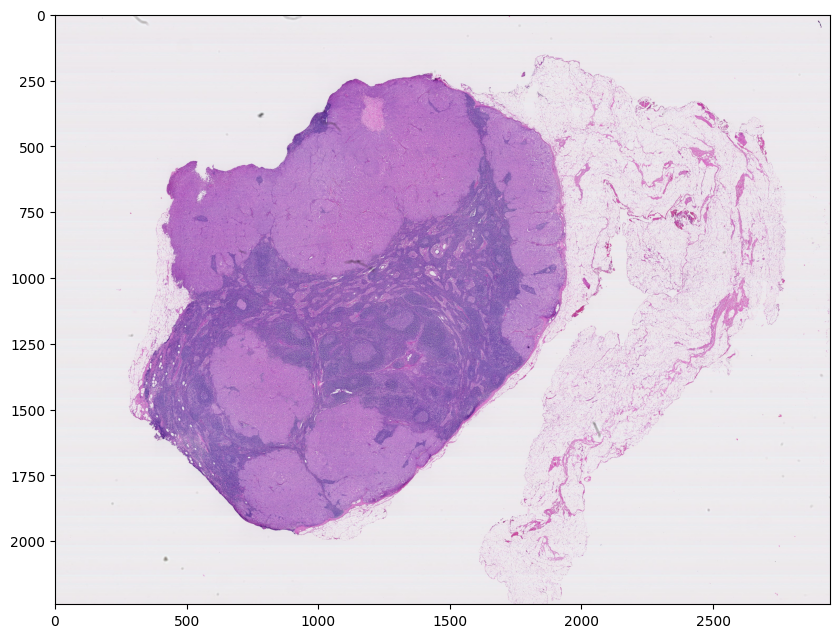

In [ ]:
# sanity check: display slide 110
slide = open_slide("tumor_110.tif")
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

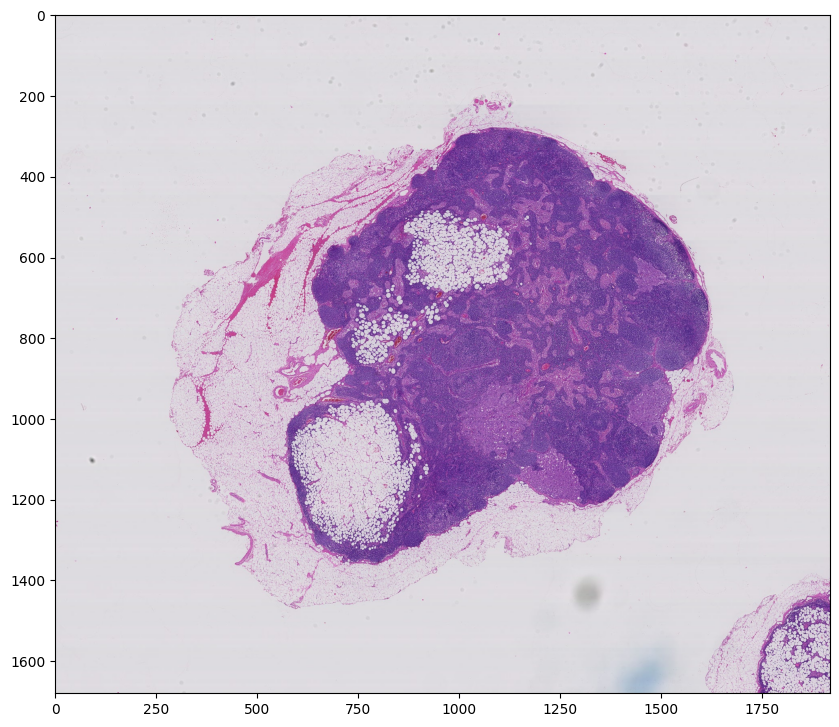

In [ ]:
# sanity check: display slide 91
slide = open_slide("tumor_091.tif")
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [ ]:
# create a pandas dataframe with columns [unique_id, image_path, zoom_level, slide_name, has_tumor]

# get all images from specified files and return list of file paths (of the images)
# return a dictionary containing {image_path: [zoom_level, slide_name, x, y, has_tumor, rotate, flip]}
def get_all_image_info(slide, isTrain=True):
  if (isTrain):
    path = f"/content/Train/{slide}"
  else:
    path = f"/content/Test/{slide}"

  # get all image path
  all_images = os.listdir(path)
  image_path = list(map(lambda x: f"{path}/{x}", all_images))

  # get all truth label
  result = {}
  for filename in image_path:
    name = os.path.basename(os.path.splitext(filename)[0]).split("_")
    level = int(name[0])
    result[filename] = (level, slide, int(name[1]), \
                        int(name[2]), \
                        int(name[3]), \
                        int(name[4]), \
                        int(name[5]))

  return result

In [ ]:
# get all images information into a dictionary: result
results = {}
for slide in train_slide_names:
    results[f"{slide}"] = get_all_image_info(slide, isTrain=True)

# group all images together to form a aggregate csv for training
train_df = pd.DataFrame()
for key, value in results.items():
  train_df = pd.concat([train_df, pd.DataFrame([{"image_path": image_path, \
                                                 "zoom_level": zoom_level, \
                                                 "slide_name": slide_name, \
                                                 "information": str([slide_name, x, y, rotate, flip, has_tumor]), \
                                                 "has_tumor": has_tumor} for image_path, [zoom_level, slide_name, x, y, has_tumor, rotate, flip] in value.items()])])

In [ ]:
train_df.head()

image_path  zoom_level  \
0  /content/Train/tumor_091.tif/0_9557_9813_1_1_0...           0   
1  /content/Train/tumor_091.tif/0_4565_4565_0_0_0...           0   
2  /content/Train/tumor_091.tif/2_7381_11221_0_0_...           2   
3  /content/Train/tumor_091.tif/0_6485_9429_0_0_0...           0   
4  /content/Train/tumor_091.tif/2_5333_5461_0_0_0...           2   

      slide_name                              information  has_tumor  
0  tumor_091.tif   ['tumor_091.tif', 9557, 9813, 1, 0, 1]          1  
1  tumor_091.tif   ['tumor_091.tif', 4565, 4565, 0, 0, 0]          0  
2  tumor_091.tif  ['tumor_091.tif', 7381, 11221, 0, 0, 0]          0  
3  tumor_091.tif   ['tumor_091.tif', 6485, 9429, 0, 0, 0]          0  
4  tumor_091.tif   ['tumor_091.tif', 5333, 5461, 0, 0, 0]          0

In [ ]:
# separate two zoom levels into 2 dataframes, then combine them into form:
# [image_path1, image_path2, label]
# TODO: this is hard-coded zoom levels
df1 = train_df.loc[train_df['zoom_level'] == train_levels[0]]
df2 = train_df.loc[train_df['zoom_level'] == train_levels[1]]

print(len(df1), len(df2))
if (len(df1) > len(df2)):
  join_method = "left"
else:
  join_method = "right"

merged_train_df = pd.merge(df1, df2, on='information', how=join_method).drop(columns=['has_tumor_x', 'zoom_level_x', 'zoom_level_y', 'slide_name_x', 'slide_name_y'])
merged_train_df = merged_train_df.rename(columns={'image_path_x': 'image_path_1', 'image_path_y': 'image_path_2', 'has_tumor_y': 'has_tumor'})
merged_train_df.head()

13757 13757


image_path_1  \
0  /content/Train/tumor_091.tif/2_9557_9813_1_1_0...   
1  /content/Train/tumor_091.tif/2_4565_4565_0_0_0...   
2  /content/Train/tumor_091.tif/2_6485_9429_0_0_0...   
3  /content/Train/tumor_091.tif/2_8021_11861_1_2_...   
4  /content/Train/tumor_091.tif/2_9173_11221_0_0_...   

                               information  \
0   ['tumor_091.tif', 9557, 9813, 1, 0, 1]   
1   ['tumor_091.tif', 4565, 4565, 0, 0, 0]   
2   ['tumor_091.tif', 6485, 9429, 0, 0, 0]   
3  ['tumor_091.tif', 8021, 11861, 2, 0, 1]   
4  ['tumor_091.tif', 9173, 11221, 0, 0, 0]   

                                        image_path_2  has_tumor  
0  /content/Train/tumor_091.tif/0_9557_9813_1_1_0...          1  
1  /content/Train/tumor_091.tif/0_4565_4565_0_0_0...          0  
2  /content/Train/tumor_091.tif/0_6485_9429_0_0_0...          0  
3  /content/Train/tumor_091.tif/0_8021_11861_1_2_...          1  
4  /content/Train/tumor_091.tif/0_9173_11221_0_0_...          0

In [ ]:
# sanity check: length of merged df should be half of original df
print(len(merged_train_df), len(train_df))
assert (len(merged_train_df) == len(train_df)/2)

13757 27514


## Load training dataframe into tensorflow dataset
1. preprocess image with step: load -> decode -> resize to 299,299,3 -> clip image range to (0,1) (not used in baseline) -> normalize with mean 0 and std 1

In [ ]:
# Define a function that loads and resizes an image
def preprocess_images_labels(file_path_1, file_path_2, label):
  global width
  global height
  # Read the image file
  image_string_1 = tf.io.read_file(file_path_1)
  image_string_2 = tf.io.read_file(file_path_2)

  # Decode the image data
  image_1 = tf.image.decode_png(image_string_1, channels=3)
  image_2 = tf.image.decode_png(image_string_2, channels=3)

  # Check if the image data is a valid tensor
  if (not tf.is_tensor(image_1)) or (not tf.is_tensor(image_2)):
      raise ValueError('Invalid image data')

  # Resize the image to (width, height) pixels
  image_1 = tf.image.resize(image_1, (width, height))
  image_2 = tf.image.resize(image_2, (width, height))

  # TODO: Clip the pixel values to the range [0, 1]
  # not used in baseline model
  # clipped_images = tf.clip_by_value(image, 0.0, 1.0)

  # Normalize the images
  image_1 = tf.image.per_image_standardization(image_1)
  image_2 = tf.image.per_image_standardization(image_2)

  # expand labels
  label = tf.expand_dims(label, 0)

  return (image_1, image_2), label

In [ ]:
# load training images and labels from csv
file_paths_1 = tf.data.Dataset.from_tensor_slices(merged_train_df['image_path_1'].values)
file_paths_2 = tf.data.Dataset.from_tensor_slices(merged_train_df['image_path_2'].values)
labels = tf.data.Dataset.from_tensor_slices(merged_train_df['has_tumor'].values)

# Create a dataset of (file path, label) tuples
train_dataset = tf.data.Dataset.zip((file_paths_1, file_paths_2, labels))

# Apply the load_and_resize_image function to the (file path, label) dataset
train_dataset = train_dataset.map(preprocess_images_labels)

# Configure the training dataset for performance
train_dataset = train_dataset.batch(train_batch_size)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Sanity check: show first element in dataset
first_element = train_dataset.take(1)

# Iterate over the element and print the value
for element in first_element:
    print(element[0][0].shape) 
    print(element[0][1].shape) 
    print(element[1])  

(8, 299, 299, 3)
(8, 299, 299, 3)
tf.Tensor(
[[1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]], shape=(8, 1), dtype=int64)


# Create Test Patches and Test Set
Reminder: test set should contain all patches of that slide
1. test_df contains all test images and their labels (if any)
2. create the testing dataset `test_dataset` and batch it
3. all_test_datasets is a dictionary where keys are slide_level and values are corresponding batched dataset
4. the code works on multiple slides and levels
5. each slide_level will have individual dataset
<!-- 
For each pixel (1,1) at lvl7:
  find a matching patch (299, 299) at lvl3:
    get a label at (128,128) of that patch
create mask for lvl7 using the labels: (480*420)
 -->

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio

In [ ]:
'''
  threshold using thresh (input)
  usage: function used in creating all_coordinates dictionary
'''
def threshold(x, thresh):
  x = np.where(x < thresh, 0, 1)
  return x

In [ ]:
'''
  usage: used to map target level's pixel to reference level's patch
  -- used by generate_heatmap_matrix function
  
  ---input---
  slide: target slide
  row, col: row and column index of target level pixel
  target_level: level used to generate heatmap
  reference_level: level used to generate reference patches for target pixel
  patch_size: the size of each generated patch, default 299
'''
def get_corresponding_patch(slide, row, col, target_level, reference_level_1, reference_level_2, patch_size=299):
  reference_slide_1 = read_slide(slide, 
                              y=row*int(slide.level_downsamples[target_level])-int(patch_size/2), 
                              x=col*int(slide.level_downsamples[target_level])-int(patch_size/2),  
                              level=reference_level_1, 
                              width=patch_size, 
                              height=patch_size)
  
  reference_slide_2 = read_slide(slide, 
                              y=(row+int(299/2))*int(slide.level_downsamples[target_level])-int(patch_size/2), 
                              x=(col+int(299/2))*int(slide.level_downsamples[target_level])-int(patch_size/2),  
                              level=reference_level_2, 
                              width=patch_size, 
                              height=patch_size)
  
  return reference_slide_1, reference_slide_2

In [ ]:
def duplicate_test_image(x1, x2):
  return (x1, x2), 0

In [ ]:
'''
  usage: create tensorflow dataset for designated patch
  -- include resize and normalization, return dataset w/ that 1 image
  ---input---
  image: reference slide
'''
def create_test_dataset(index, image1, image2):
  batch_size = 1
  width, height = 299, 299

  # Resize the image to designated size
  # image1 = tf.image.resize(image1, (width, height), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # image2 = tf.image.resize(image2, (width, height), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # Normalize the images
  image1 = tf.image.per_image_standardization(image1)
  # imageio.imwrite(f'/content/Test/{str(index)}.png', image1)
  image2 = tf.image.per_image_standardization(image2)

  # Add a batch dimension
  image1 = tf.expand_dims(image1, 0) 
  image2 = tf.expand_dims(image2, 0) 

  # Create a dataset from image
  dataset1 = tf.data.Dataset.from_tensor_slices(image1)
  dataset2 = tf.data.Dataset.from_tensor_slices(image2)
  dataset = tf.data.Dataset.zip((dataset1, dataset2))

  # duplicate image for model
  dataset = dataset.map(duplicate_test_image)
  dataset = dataset.batch(1)

  # sanity check: Iterate over the element and print the value
  # for element in first_element:
  #   assert element.shape == [width, height, 3]

  return dataset

# Train Model
1. create baseline-0 model using transfer learning:

  a. install weights if InceptionV3
  
  b. pretrained InceptionV3 on imagenet

In [ ]:
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.models import Model
# from keras.layers.merge import concatenate

In [ ]:
# Load the InceptionV3 model, use a slimmed-down version of the model for efficiency
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(width, height, 3))
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(width, height, 3), depth_multiplier=0.1)
base_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# define data augmentation steps
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_brightness(x, delta=64/255)),
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_saturation(x, saturation_factor=0.25)),
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_hue(x, delta=0.04)),
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_contrast(x, contrast_factor=0.75))
])

In [ ]:
# MODEL 1
# add trainable additional fully connected layer
inputs1 = tf.keras.Input(shape=(width, height, 3))
x1 = data_augmentation(inputs1)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1) # flatten
outputs1 = Dense(128)(x1)

# combine the models
model_lvl1 = tf.keras.Model(inputs1, outputs1)
model_lvl1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 22,065,056
Trainable params: 262,272
Non-trainable params: 21,802,784
___________________________________________

In [ ]:
# MODEL 2
# add trainable additional fully connected layer
inputs2 = tf.keras.Input(shape=(width, height, 3))
x2 = data_augmentation(inputs2)
x2 = base_model(x2, training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2) # flatten
outputs2 = Dense(128)(x2)

model_lvl2 = tf.keras.Model(inputs2, outputs2)
model_lvl2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
Total params: 22,065,056
Trainable params: 262,272
Non-trainable params: 21,802,784
_________________________________________

In [ ]:
# Concatenate the output of the two models
concatenated = tf.keras.layers.Concatenate()([outputs1, outputs2])

x = Dense(32, activation='relu')(concatenated)
outputs = Dense(1, activation='sigmoid')(x)

# Define the model using the input layers and the final prediction
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

# Sanity check: model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 299, 299, 3)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.002, momentum=0.9, epsilon=1, decay=0.9)
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss_func, metrics=['binary_accuracy'])

In [ ]:
# Fit the model on your training data
model.fit(train_dataset, epochs=10, validation_data=train_dataset)

Epoch 1/10
1720/1720 [==============================] - 324s 178ms/step - loss: 0.1471 - binary_accuracy: 0.9450 - val_loss: 0.1963 - val_binary_accuracy: 0.9325
Epoch 2/10
1720/1720 [==============================] - 303s 176ms/step - loss: 0.1060 - binary_accuracy: 0.9613 - val_loss: 0.1420 - val_binary_accuracy: 0.9477
Epoch 3/10
1720/1720 [==============================] - 294s 171ms/step - loss: 0.0876 - binary_accuracy: 0.9675 - val_loss: 0.1141 - val_binary_accuracy: 0.9562
Epoch 4/10
1720/1720 [==============================] - 287s 167ms/step - loss: 0.0749 - binary_accuracy: 0.9735 - val_loss: 0.0930 - val_binary_accuracy: 0.9635
Epoch 5/10
1720/1720 [==============================] - 303s 176ms/step - loss: 0.0655 - binary_accuracy: 0.9772 - val_loss: 0.0861 - val_binary_accuracy: 0.9672
Epoch 6/10
1720/1720 [==============================] - 288s 167ms/step - loss: 0.0577 - binary_accuracy: 0.9798 - val_loss: 0.0749 - val_binary_accuracy: 0.9717
Epoch 7/10
1720/1720 [======

In [ ]:
# save the model
tf.keras.models.save_model(model, 'baseline2.h5')

# Evaulation Metrics

In [ ]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, r2_score

In [ ]:
'''
  compute evaluation scores for slide_level, including AUC, Precision, Recall, R2
  --- input ---
  heat_matrix: predicted label at training level (reference level)
  mask_image: truth label at level (target level)
  slide: current slide name
  level: level used for generating training set
'''
def compute_score(heat_matrix, mask_image, slide, level):
  print("Evaluation Started...")
  heat_matrix = threshold(heat_matrix, 0.5)
  
  # compute AUC for predictions
  pred_labels = heat_matrix.flatten().astype(int)
  truth_labels = mask_image.flatten().astype(int)
  fpr, tpr, thresholds = metrics.roc_curve(truth_labels, pred_labels)
  print(f"AUC score for {slide} at training level {level}: {metrics.auc(fpr, tpr)}")

  # compute precision
  macro_precision = precision_score(truth_labels, pred_labels, average='macro')
  micro_precision = precision_score(truth_labels, pred_labels, average='micro')
  weighted_precision = precision_score(truth_labels, pred_labels, average='weighted')
  print(f"Precision scores: \n Macro: {macro_precision} \n Micro: {micro_precision} \n Weighted: {weighted_precision}")

  # compute recall
  macro_recall = recall_score(truth_labels, pred_labels, average='macro')
  micro_recall = recall_score(truth_labels, pred_labels, average='micro')
  weighted_recall = recall_score(truth_labels, pred_labels, average='weighted')
  print(f"Recall scores: \n Macro: {macro_recall} \n Micro: {micro_recall} \n Weighted: {weighted_recall}")

  # compute r2 score
  print(f"R2 score: {r2_score(truth_labels, pred_labels)}")
  print("Evaluation Finished...")

# Generate Heat Map
1. generate heat map for each test slides


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import random
import imageio
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load model
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/4995 Applied Deep Learning/final_project/baseline2.h5')

In [ ]:
# Save numpy array to a file
def save_numpy(filename, heat_matrix):
  np.savetxt(filename, heat_matrix)
  print("file saved")

In [ ]:
def check_in_range(i, j, width, height):
  return (i >= 0) and (i < width) and (j >= 0) and (j < height)

In [ ]:
'''
  generate heatmap matrix for single slide with defined target_level and reference level
  ---input---
  slide: current slide
  target_level: level used for sliding pixels
  reference_level: level used to get patch (of corresponding pixel)
  doThreshold: output label or probability distribution
'''
test_dataset = None # DELETE
def generate_heatmap_matrix(slide, target_level=7, reference_level_1=1, reference_level_2=1, doThreshold=False, upsample=3):
  global saved_model
  global test_dataset # DELETE
  
  # get slide at target level, deault level7
  target_slide = read_slide(slide, 
                            x=0, 
                            y=0, 
                            level=target_level, 
                            width=slide.level_dimensions[target_level][0], 
                            height=slide.level_dimensions[target_level][1])
  
  # sanity check: show target slide
  # plt.figure(figsize=(10,10), dpi=100)
  # plt.imshow(target_slide)

  # convert slide to grey and check whether pixel is background or cell
  is_cell = rgb2gray(target_slide) <= 0.8

  width, height = target_slide.shape[0], target_slide.shape[1]
  
  # generate a prediction matrix that is used for generating heatmap
  result_matrix = np.zeros((width, height))

  # intialize upsample pixel check (0: not predicted, 1: predicted)
  predicted_pixels = np.zeros((width, height)).astype(int)

  # sanity check: original image
  original_slide = np.zeros((width, height, 3)).astype(int)

  counter = 0
  for i in tqdm(range(width)):
    for j in range(height):
      original_slide[i][j][0] = target_slide[i][j][0]
      original_slide[i][j][1] = target_slide[i][j][1]
      original_slide[i][j][2] = target_slide[i][j][2]
      
      # if not yet predicted
      if (predicted_pixels[i][j] == 0):
        # mark pixel (i,j) as predicted
        predicted_pixels[i][j] = 1

        # proceed only if not background cell and not predicted
        if (is_cell[i][j]):
          # get patch for each pixel of target_slide 
          reference_slide_1, reference_slide_2 = get_corresponding_patch(slide, i, j, target_level, reference_level_1, reference_level_2, patch_size=299)

          # sanity check: save 5 reference slide to see whether coordinate mapping works
          if (counter <= 4):
            if (random.randint(0, 101) % 100 == 0):
              counter += 1
              with warnings.catch_warnings():
                  # Suppress warnings
                  warnings.simplefilter("ignore")
              imageio.imwrite(f'reference_slide{counter}.png', reference_slide_1)

          # create dataset for this slide
          test_dataset = create_test_dataset((i, j), reference_slide_1, reference_slide_2)

          # get prediction for this slide
          predictions = saved_model.predict(test_dataset, verbose=0).squeeze()

          # either do threshold to get absolute label or probability distribution
          predicted_label = predictions
          if (doThreshold):
            predicted_label = threshold(predictions, 0.5)

          # insert the prediction into matrix
          result_matrix[i][j] = predicted_label

          if (upsample == 0):
            all_index = []
          elif (upsample == 1):
            all_index = [(i+a, j+b) for a in range(-1, 2) for b in range(-1, 2)]
          elif (upsample == 2):
            all_index = [(i+a, j+b) for a in range(-2, 3) for b in range(-2, 3)]
          elif (upsample == 3):
            all_index = [(i+a, j+b) for a in range(-3, 4) for b in range(-3, 4)]
          elif (upsample == 4):
            all_index = [(i+a, j+b) for a in range(-4, 5) for b in range(-4, 5)]
          else:
            all_index = [(i+a, j+b) for a in range(-upsample, upsample+1) for b in range(-upsample, upsample+1)]

          for (r, c) in all_index:
            if (check_in_range(r, c, width, height)) and (predicted_pixels[r][c] == 0):
              # use predicted cell to mark surrounding cell
              result_matrix[r][c] = predicted_label

              # mark as predicted
              predicted_pixels[r][c] = 1

  # sanity check: whether all pixels are labeled predicted
  assert (predicted_pixels == 1).all()

  return result_matrix, predicted_pixels, original_slide

In [ ]:
'''
  usage: generate heatmap for 1 slide
  slide_path: current slide
  target_level: level used for sliding pixels
  reference_level: level used to get patch (of corresponding pixel)
  upsample_level: reducing number of pixels needed to compute
    -- level 0: compute every pixel
    -- level 1: 3*3 upsample
    -- level 2: 5*5 upsample
    -- level 3: 7*7 upsample
    -- level 3: 9*9 upsample
'''
heat_matrix = None
def display_heatmap_mask(slide_path, target_level, reference_level_1, reference_level_2, upsample_level=3):
  # open slide
  cell_slide = open_slide(slide_path)

  # designated filename for storing heat matrix
  filename = f"/content/{slide_path}_heat_matrix.txt"

  # save generated result or read from result
  predicted_pixels = None
  if os.path.exists(filename):
    # read matrix into numpy array
    heat_matrix = np.loadtxt(filename)
  else:
    # get matrices for slide-level and save it into a txt
    heat_matrix, predicted_pixels, original_slide = generate_heatmap_matrix(cell_slide, target_level, \
                                                            reference_level_1, reference_level_2, doThreshold=False, \
                                                            upsample=upsample_level)
    
    save_numpy(filename, heat_matrix)

  # get mask for slide-level
  tumor_mask_path = f"{os.path.splitext(slide_path)[0]}_mask.tif"
  tumor_mask = open_slide(tumor_mask_path)

  mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=target_level, 
                          width=cell_slide.level_dimensions[target_level][0], 
                          height=cell_slide.level_dimensions[target_level][1])
  
  # draw heatmap and mask side by side
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))
  axes[0].imshow(heat_matrix)

  mask_image = mask_image[:,:,0]
  axes[1].imshow(mask_image)

  return heat_matrix, predicted_pixels, mask_image, original_slide

# Generate Results

In [ ]:
# !zip -r /content/test.zip /content/Test/

In [ ]:
# !zip -r /content/tumor_091.zip /content/Train/tumor_091.tif

In [ ]:
# sanity check: get score on train dataset
prediction = model.predict(train_dataset, verbose=0)

all_labels = []
for example in train_dataset:
  if (example[1].shape[0] == 1):
    label = list(example[1].numpy()[0])
  else:
    label = list(example[1].numpy().squeeze())
  all_labels.append(label)

from itertools import chain

def flatten(lst):
    return list(chain.from_iterable(lst))

all_labels = flatten(all_labels)

print(compute_score(prediction, np.array(all_labels), 0, 0))

Evaluation Started...
AUC score for 0 at training level 0: 0.9656564370748448
Precision scores: 
 Macro: 0.9683115529789867 
 Micro: 0.9680162826197573 
 Weighted: 0.9680398589094767
Recall scores: 
 Macro: 0.9656564370748447 
 Micro: 0.9680162826197573 
 Weighted: 0.9680162826197573
R2 score: 0.8680595396073357
Evaluation Finished...
None


100%|██████████| 560/560 [07:43<00:00,  1.21it/s]


file saved
Evaluation Started...
AUC score for tumor_110.tif at training level 2: 0.9757178057690893
Precision scores: 
 Macro: 0.9436707178582175 
 Micro: 0.9775111607142857 
 Weighted: 0.9789575801841596
Recall scores: 
 Macro: 0.9757178057690893 
 Micro: 0.9775111607142857 
 Weighted: 0.9775111607142857
R2 score: 0.8291281525081997
Evaluation Finished...


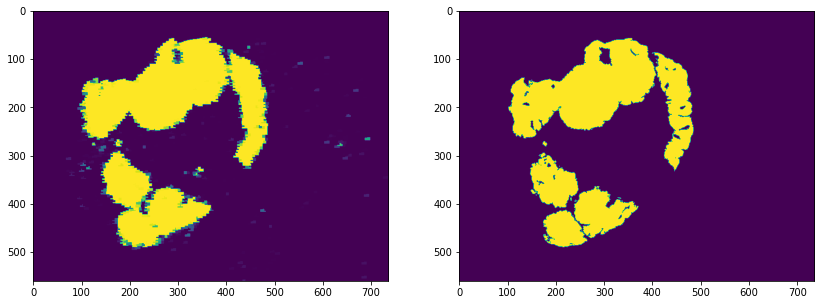

In [ ]:
# prediction of all pixels at level7 with its patch mapping at level3
# with an upsample of level3 (7*7)
slide_path = 'tumor_110.tif'
heat_matrix, predicted_pixels, mask_image, original_slide = display_heatmap_mask(slide_path, target_level=7, reference_level_1=2, reference_level_2=0, upsample_level=5)

# compute evaluation metric
compute_score(heat_matrix, mask_image, "tumor_110.tif", 2)

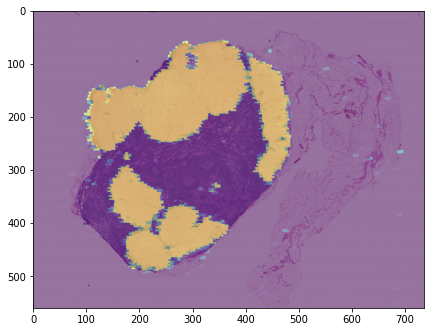

In [ ]:
slide = open_slide("tumor_110.tif")
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

plt.figure(figsize=(7,7))
plt.imshow(heat_matrix)
plt.imshow(slide_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

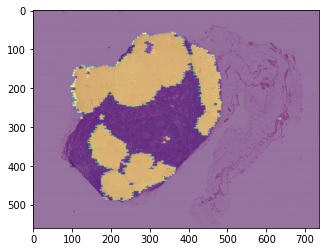

In [ ]:
# thresholded prediction
plt.imshow(threshold(heat_matrix, 0.5))
plt.imshow(slide_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

100%|██████████| 420/420 [03:18<00:00,  2.11it/s]


file saved
Evaluation Started...
AUC score for tumor_091.tif at training level 2: 0.864445026898864
Precision scores: 
 Macro: 0.7094228890430995 
 Micro: 0.981547619047619 
 Weighted: 0.987868955845558
Recall scores: 
 Macro: 0.8644450268988639 
 Micro: 0.981547619047619 
 Weighted: 0.981547619047619
R2 score: -0.2909537747274096
Evaluation Finished...


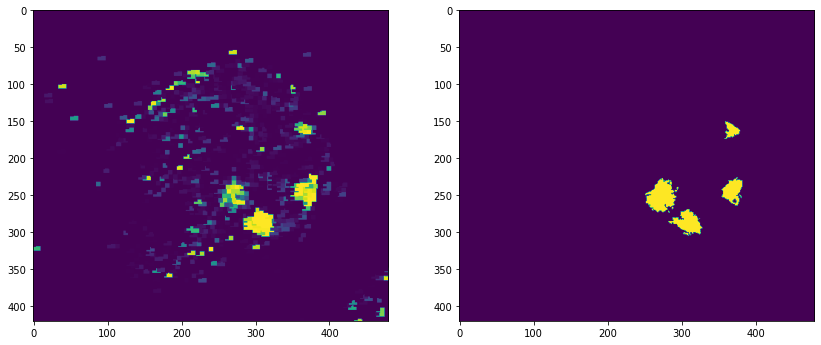

In [ ]:
# prediction of all pixels at level7 with its patch mapping at level3
# with an upsample of level3 (7*7)
slide_path = 'tumor_091.tif'
heat_matrix, predicted_pixels, mask_image, original_slide = display_heatmap_mask(slide_path, target_level=7, reference_level_1=2, reference_level_2=0, upsample_level=5)

# compute evaluation metric
compute_score(heat_matrix, mask_image, "tumor_091.tif", 2)

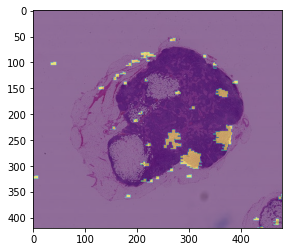

In [ ]:
# thresholded prediction
slide = open_slide("tumor_091.tif")
heat_matrix = np.loadtxt('/content/tumor_091.tif_heat_matrix.txt')
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])


plt.imshow(threshold(heat_matrix, 0.5))
plt.imshow(slide_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
# external test dataset (94)
slide_url = "https://storage.googleapis.com/medical_images_tif/94/tumor_094.tif"
mask_url = "https://storage.googleapis.com/medical_images_tif/94/tumor_094_mask.tif"

slide_name = "tumor_094.tif"
tumor_mask_path = "tumor_094_mask.tif"

# Download the whole slide image
if not os.path.exists(slide_name):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1534M  100 1534M    0     0   156M      0  0:00:09  0:00:09 --:--:--  160M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.7M  100 51.7M    0     0  92.2M      0 --:--:-- --:--:-- --:--:-- 92.2M


100%|██████████| 784/784 [04:40<00:00,  2.79it/s]


file saved
Evaluation Started...
AUC score for tumor_094.tif at training level 2: 0.9691377403319934
Precision scores: 
 Macro: 0.5677537874954457 
 Micro: 0.9672545742434905 
 Weighted: 0.9952886752565318
Recall scores: 
 Macro: 0.9691377403319935 
 Micro: 0.9672545742434905 
 Weighted: 0.9672545742434905
R2 score: -5.2484158536036505
Evaluation Finished...


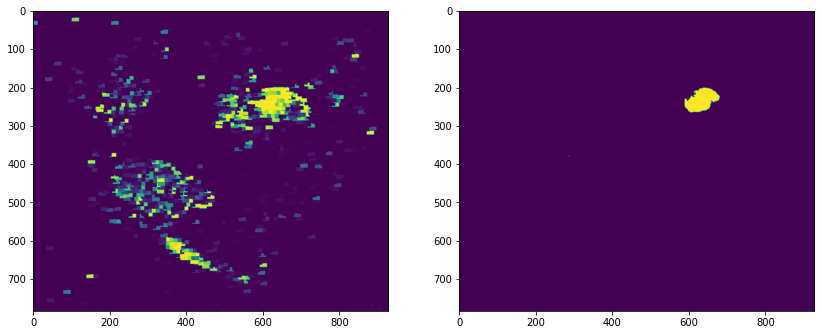

In [ ]:
# prediction of all pixels at level7 with its patch mapping at level3
# with an upsample of level3 (7*7)
slide_path = 'tumor_094.tif'
heat_matrix, predicted_pixels, mask_image, original_slide = display_heatmap_mask(slide_path, target_level=7, reference_level_1=2, reference_level_2=0, upsample_level=9)

# compute evaluation metric
compute_score(heat_matrix, mask_image, "tumor_094.tif", 2)

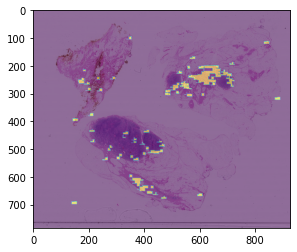

In [ ]:
# thresholded prediction
slide = open_slide("tumor_094.tif")
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])


plt.imshow(threshold(heat_matrix, 0.5))
plt.imshow(slide_image, cmap='jet', alpha=0.5) # Red regions contains cancer.